In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve
from scipy.spatial.distance import pdist, squareform

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
# Setup a pytorch model, where a, b, and c are parameters. Use some arbitrary values for the parameters to begin with.
class Parabola(torch.nn.Module):
    def __init__(self, a=1, b=1, c=1):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(float(a)))
        self.b = torch.nn.Parameter(torch.tensor(float(b)))
        self.c = torch.nn.Parameter(torch.tensor(float(c)))
    
    def forward(self, x):
        return self.a*x**2 + self.b*x + self.c
    
    def autograd(self, x):
        y = self.forward(x)
        dydx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
        return dydx

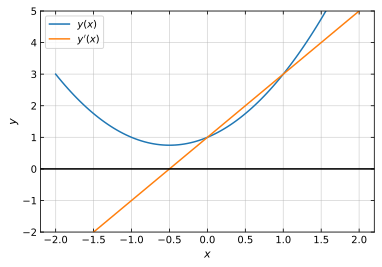

In [3]:
# Plot y(x). If you feel like recapping the topic of the previous exercises, use autodifferentiation and plot y′(x).
p = Parabola()
xs = torch.linspace(-2, 2, 100, requires_grad=True)
ys = p.forward(xs)
dydxs = p.autograd(xs)

fig, ax = plt.subplots(figsize=(6, 4))
with torch.no_grad():
    ax.plot(xs, ys, label='$y(x)$')
    ax.plot(xs, dydxs, label='$y\'(x)$')
ax.set(xlabel='$x$', ylabel='$y$', ylim=(-2,5))
ax.axhline(0, c='k')
ax.grid(alpha=0.5)
ax.legend()

fig.savefig('ex44_fig1.png')

Step 0, loss 327.3333435058594
Step 1000, loss 0.974776566028595
Step 2000, loss 0.6094802618026733
Step 3000, loss 0.40578362345695496
Step 4000, loss 0.20373095571994781
Step 5000, loss 0.06466067582368851
Step 6000, loss 0.009641281329095364
Step 7000, loss 0.0004092402814421803
Step 8000, loss 2.1121377358213067e-06
Step 9000, loss 3.0089589153625695e-10


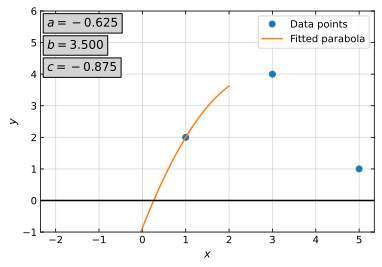

In [4]:
# Fitting
p = Parabola()
data = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 1.0]])
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p.parameters(), lr=0.01)

steps = 10000
for step in range(steps):
    optimizer.zero_grad()
    loss = loss_func(p.forward(data[:,0]), data[:,1])
    loss.backward()
    optimizer.step()
    if step % 1000 == 0:
        print(f'Step {step}, loss {loss.item()}')

# Plot the data points and the fitted parabola.
fig, ax = plt.subplots(figsize=(6, 4))
with torch.no_grad():
    ax.plot(data[:,0], data[:,1], 'o', label='Data points')
    ax.plot(xs, p.forward(xs), label='Fitted parabola')
ax.text(0.02, 0.97, fr'$a = {p.a.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.text(0.02, 0.87, fr'$b = {p.b.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.text(0.02, 0.77, fr'$c = {p.c.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.set(xlabel='$x$', ylabel='$y$', ylim=(-1,6))
ax.axhline(0, c='k')
ax.grid(alpha=0.5)
ax.legend()

fig.savefig('ex44_fig2.png')

Step 0, loss 5.6449875831604


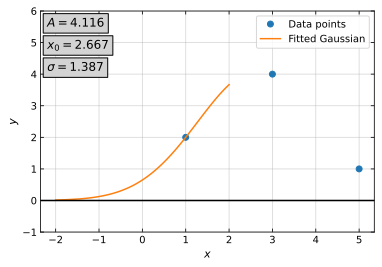

In [5]:
class Gaussian(torch.nn.Module):
    def __init__(self, A=1, x0=1, sigma=1):
        super().__init__()
        self.A = torch.nn.Parameter(torch.tensor(float(A)))
        self.x0 = torch.nn.Parameter(torch.tensor(float(x0)))
        self.sigma = torch.nn.Parameter(torch.tensor(float(sigma)))
    
    def forward(self, x):
        return self.A * torch.exp(-0.5*(x-self.x0)**2/self.sigma**2)
    
    def autograd(self, x):
        y = self.forward(x)
        dydx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
        return dydx

# Fitting the same points as before, but now with a Gaussian function.
g = Gaussian()
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(g.parameters(), lr=0.01)

steps = 1000
for step in range(steps):
    optimizer.zero_grad()
    loss = loss_func(g.forward(data[:,0]), data[:,1])
    loss.backward()
    optimizer.step()
    if step % 1000 == 0:
        print(f'Step {step}, loss {loss.item()}')

# Plot the data points and the fitted Gaussian.
fig, ax = plt.subplots(figsize=(6, 4))
with torch.no_grad():
    ax.plot(data[:,0], data[:,1], 'o', label='Data points')
    ax.plot(xs, g.forward(xs), label='Fitted Gaussian')
ax.text(0.02, 0.97, fr'$A = {g.A.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.text(0.02, 0.87, fr'$x_0 = {g.x0.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.text(0.02, 0.77, fr'$\sigma = {g.sigma.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.set(xlabel='$x$', ylabel='$y$', ylim=(-1,6))
ax.axhline(0, c='k')
ax.grid(alpha=0.5)
ax.legend()

fig.savefig('ex44_fig3.png')

Step 0, loss 1.1759546995162964
Step 1000, loss 1.231607372510768e-12
Step 2000, loss 9.473902782067278e-13


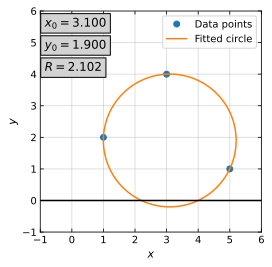

In [6]:
# Setup a model for a circle.
class Circle(torch.nn.Module):
    def __init__(self, x0=3, y0=2, R=1):
        super().__init__()
        self.x0 = torch.nn.Parameter(torch.tensor(float(x0)))
        self.y0 = torch.nn.Parameter(torch.tensor(float(y0)))
        self.R = torch.nn.Parameter(torch.tensor(float(R)))
    
    def mean_squared_dist(self, x_arr, y_arr):
        dists_to_center = torch.sqrt((x_arr - self.x0)**2 + (y_arr - self.y0)**2) - self.R
        squared_dists = dists_to_center**2
        mean_squared_dist = torch.mean(squared_dists)
        return mean_squared_dist

# Fitting a circle to the data points.
c = Circle()
optimizer = torch.optim.Adam(c.parameters(), lr=0.01)

steps = 3000
for step in range(steps):
    optimizer.zero_grad()
    loss = c.mean_squared_dist(*data.T)
    loss.backward()
    optimizer.step()
    if step % 1000 == 0:
        print(f'Step {step}, loss {loss.item()}')

# Plot the data points and the fitted circle.
fig, ax = plt.subplots(figsize=(6, 4))
with torch.no_grad():
    ax.plot(data[:,0], data[:,1], 'o', label='Data points')
    thetas = torch.linspace(0, 2*np.pi, 100)
    xs = c.x0.item() + c.R.item()*torch.cos(thetas)
    ys = c.y0.item() + c.R.item()*torch.sin(thetas)
    ax.plot(xs, ys, label='Fitted circle')
ax.text(0.02, 0.97, fr'$x_0 = {c.x0.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.text(0.02, 0.87, fr'$y_0 = {c.y0.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.text(0.02, 0.77, fr'$R = {c.R.item():.3f}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey'))
ax.set(xlabel='$x$', ylabel='$y$', xlim=(-1,6), ylim=(-1,6), aspect='equal')
ax.axhline(0, c='k')
ax.grid(alpha=0.5)
ax.legend()

fig.savefig('ex44_fig4.png')